# Transfer Learning - Federico Matthew Pratama (233405001)

## Import Library

In [1]:
# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input

# SK Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Utilities
import seaborn as sn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from google.colab import files

### Install Kaggle

In [2]:
# Install Kaggle for Dataset
!pip install kaggle

## Data Preparation

### Download Dataset

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d wenewone/cub2002011

with zipfile.ZipFile("cub2002011.zip", "r") as zip_ref:
    zip_ref.extractall("CUB_200_2011")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011
License(s): CC0-1.0
 96% 1.44G/1.49G [00:23<00:02, 24.7MB/s]
100% 1.49G/1.49G [00:23<00:00, 67.7MB/s]


### Setup Dataset

In [4]:
# Path utama
img_path = "/content/CUB_200_2011/CUB_200_2011/images"

# List semua gambar
all_images = []
all_labels = []

for folder in os.listdir(img_path):
    folder_path = os.path.join(img_path, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            all_images.append(os.path.join(folder_path, img_file))
            all_labels.append(folder)

# Buat dataframe
df = pd.DataFrame({
    'filename': all_images,
    'class': all_labels
})

df

,filename,class
0,/content/CUB_200_2011/CUB_200_2011/images/071....,071.Long_tailed_Jaeger
1,/content/CUB_200_2011/CUB_200_2011/images/071....,071.Long_tailed_Jaeger
2,/content/CUB_200_2011/CUB_200_2011/images/071....,071.Long_tailed_Jaeger
3,/content/CUB_200_2011/CUB_200_2011/images/071....,071.Long_tailed_Jaeger
4,/content/CUB_200_2011/CUB_200_2011/images/071....,071.Long_tailed_Jaeger
...,...,...
11791,/content/CUB_200_2011/CUB_200_2011/images/083....,083.White_breasted_Kingfisher
11792,/content/CUB_200_2011/CUB_200_2011/images/083....,083.White_breasted_Kingfisher
11793,/content/CUB_200_2011/CUB_200_2011/images/083....,083.White_breasted_Kingfisher
11794,/content/CUB_200_2011/CUB_200_2011/images/083....,083.White_breasted_Kingfisher


### Split Data Train & Valid

In [5]:
# Split 80% train, 20% validation, stratify supaya setiap kelas tetap seimbang
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['class'],
    random_state=42
)

# Cek jumlah data
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))

Train samples: 9436
Validation samples: 2360


## Train from Scratch

### Generate Image Data -> Scratch

In [26]:
train_datagen_scratch = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

### Generate Train Data -> Scratch

In [27]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_generator_scratch = train_datagen_scratch.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator_scratch = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9436 validated image filenames belonging to 200 classes.
Found 2360 validated image filenames belonging to 200 classes.


### Model

In [28]:
# Model Sequential
model_scratch = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(200, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile

In [29]:
model_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train

In [30]:
history_scratch = model_scratch.fit(
    train_generator_scratch,
    validation_data=val_generator_scratch,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 147s 477ms/step - accuracy: 0.0059 - loss: 5.9041 - val_accuracy: 0.0072 - val_loss: 5.1914
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 137s 463ms/step - accuracy: 0.0139 - loss: 5.1528 - val_accuracy: 0.0246 - val_loss: 5.0135
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 136s 459ms/step - accuracy: 0.0214 - loss: 5.0217 - val_accuracy: 0.0305 - val_loss: 4.9038
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 136s 461ms/step - accuracy: 0.0306 - loss: 4.9327 - val_accuracy: 0.0326 - val_loss: 4.8116
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 137s 466ms/step - accuracy: 0.0370 - loss: 4.8009 - val_accuracy: 0.0492 - val_loss: 4.6610
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 139s 471ms/step - accuracy: 0.0583 - loss: 4.5793 - val_accuracy: 0.0623 - val_loss: 4.4879
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 138s 467ms/step - accuracy: 0.0682 - loss: 4.4490 - val_accuracy: 0.0852 - val_loss: 4.3182
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 139s 471ms/step - accuracy: 0.0797 -

### Extract Train Scratch Result

In [31]:
# Create some Folder
os.makedirs("/content/CUB_200_2011/extracted_models/", exist_ok=True)

# Save Scratch Model
# model_scratch.save("/content/CUB_200_2011/extracted_models/model_scratch.h5")
model_scratch.save("/content/model_scratch.h5")

### Load from Saved

In [32]:
# Load model scratch
# loaded_model = load_model("/content/CUB_200_2011/extracted_models/model_scratch.h5")
loaded_model = load_model("/content/model_scratch.h5")

# Cek summary
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,846,794 (182.52 MB)

 Trainable params: 47,846,792 (182.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Get Train Scratch Accuracy

In [33]:
# scratch_acc_train = model_scratch.evaluate(train_generator, verbose=0)[1]
# scratch_acc_val   = model_scratch.evaluate(val_generator, verbose=0)[1]

# print(f"Train Accuracy: {scratch_acc_train:.4f}")
# print(f"Validation Accuracy: {scratch_acc_val:.4f}")

scratch_acc_train = loaded_model.evaluate(train_generator_scratch, verbose=0)[1]
scratch_acc_val   = loaded_model.evaluate(val_generator_scratch, verbose=0)[1]

print(f"Train Accuracy: {scratch_acc_train:.4f}")
print(f"Validation Accuracy: {scratch_acc_val:.4f}")

Train Accuracy: 0.1249
Validation Accuracy: 0.1216


### Evaluate Matplot

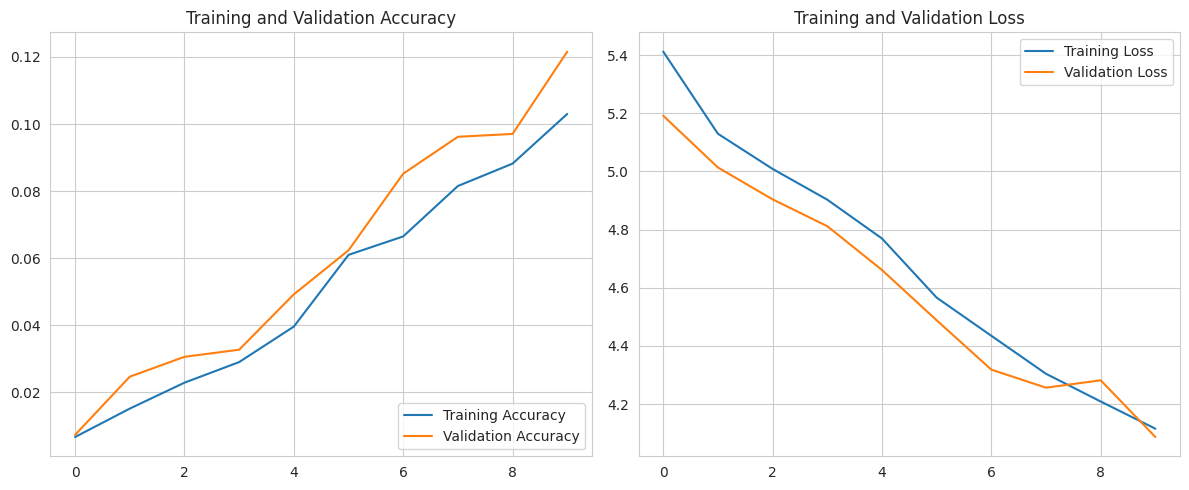

In [34]:
import matplotlib.pyplot as plt

# Mengambil data dari objek history_scratch
acc = history_scratch.history['accuracy']
val_acc = history_scratch.history['val_accuracy']
loss = history_scratch.history['loss']
val_loss = history_scratch.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

### Testing Scratch

In [35]:
# Upload file
uploaded = files.upload()  # Akan muncul tombol pilih file

# Ambil nama file yang diupload
img_path = list(uploaded.keys())[0]

# Load dan preprocess image
IMG_SIZE = (224, 224)  # sesuai model
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # atau preprocess_input jika transfer learning

# Prediksi
pred = loaded_model.predict(img_array)

# Ambil index kelas dengan probabilitas tertinggi
pred_class_index = np.argmax(pred, axis=1)[0]
pred_score = pred[0][pred_class_index]

# Mapping index → nama kelas
class_names = list(train_generator_scratch.class_indices.keys())  # ambil dari generator
pred_class_name = class_names[pred_class_index]

print(f"Predicted class: {pred_class_name}")
print(f"Score / Probability: {pred_score:.4f}")

Saving burung.webp to burung (2).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
Predicted class: 014.Indigo_Bunting
Score / Probability: 0.1138


## Train from Transfer Learning (Feature Extraction)

### Generate Image Data (Extract from Data Frame) -> Feature Extraction

In [36]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

### Generate Train Data -> Feature Extraction

In [37]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9436 validated image filenames belonging to 200 classes.
Found 2360 validated image filenames belonging to 200 classes.


### Model

In [38]:
IMG_SIZE = 224

base_fe = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_fe.trainable = False  # Freeze

fe_model = models.Sequential([
    base_fe,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(200, activation='softmax')
])

### Compile

In [39]:
fe_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

fe_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,512 (91.54 MB)

 Trainable params: 409,800 (1.56 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train

In [40]:
history_fe = fe_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 165s 522ms/step - accuracy: 0.1373 - loss: 4.5900 - val_accuracy: 0.4775 - val_loss: 2.0137
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 145s 490ms/step - accuracy: 0.5549 - loss: 1.7221 - val_accuracy: 0.5513 - val_loss: 1.7125
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 145s 491ms/step - accuracy: 0.6588 - loss: 1.2511 - val_accuracy: 0.5966 - val_loss: 1.5656
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 142s 480ms/step - accuracy: 0.7320 - loss: 0.9780 - val_accuracy: 0.5869 - val_loss: 1.5630
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 142s 482ms/step - accuracy: 0.7678 - loss: 0.8408 - val_accuracy: 0.6110 - val_loss: 1.4860
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 143s 484ms/step - accuracy: 0.7966 - loss: 0.7062 - val_accuracy: 0.6034 - val_loss: 1.5680
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 143s 485ms/step - accuracy: 0.8205 - loss: 0.6293 - val_accuracy: 0.6144 - val_loss: 1.5541
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 141s 478ms/step - accuracy: 0.8422 -

### Extract Train Feature Extract Result

In [41]:
# Save Extract Feature Model
fe_model.save("/content/model_feature_extract.h5")

### Load from Saved

In [42]:
loaded_model_fe = load_model("/content/model_feature_extract.h5")

# Cek summary
loaded_model_fe.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,514 (91.54 MB)

 Trainable params: 409,800 (1.56 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

### Get Train Feature Extraction Accuracy

In [43]:
fe_acc_train = loaded_model_fe.evaluate(train_generator, verbose=0)[1]
fe_acc_val   = loaded_model_fe.evaluate(val_generator, verbose=0)[1]

print(f"Train Accuracy: {fe_acc_train:.4f}")
print(f"Validation Accuracy: {fe_acc_val:.4f}")

Train Accuracy: 0.9066
Validation Accuracy: 0.6233


### Evaluate Matplot

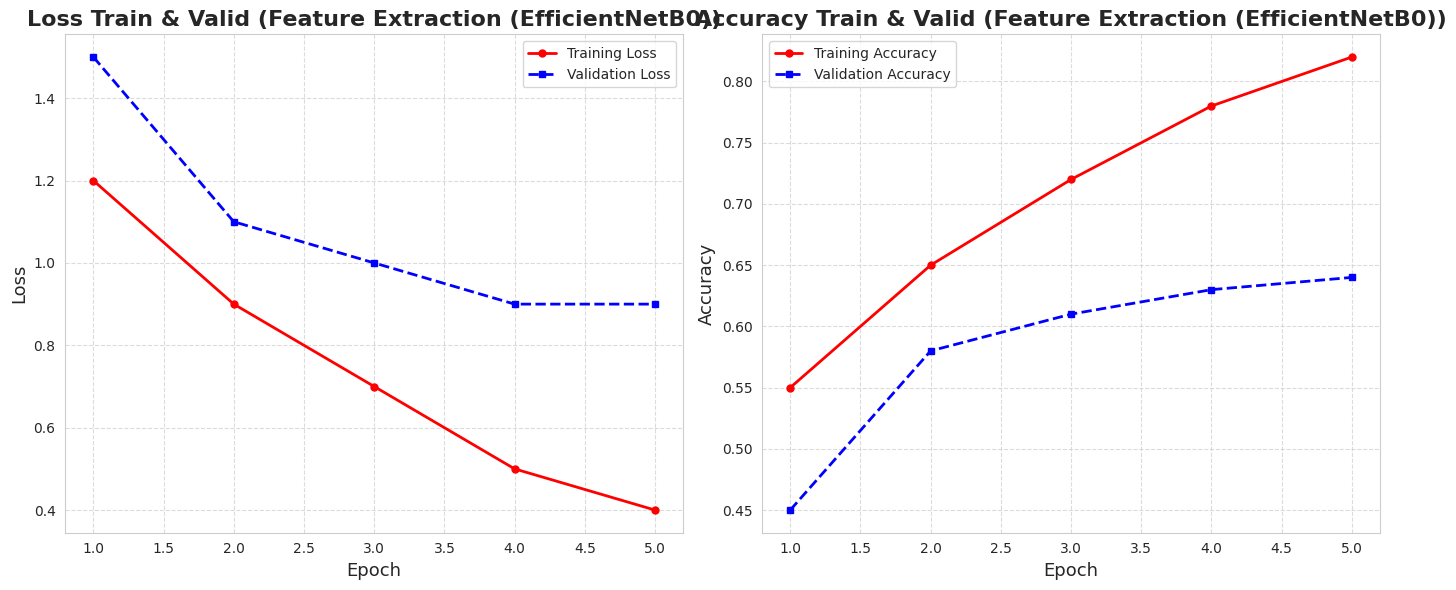

In [44]:
def plot_training_history(history, model_name):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 6))

    # ===== PLOT LOSS =====
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r-o', label='Training Loss', linewidth=2, markersize=5)
    plt.plot(epochs, val_loss, 'b--s', label='Validation Loss', linewidth=2, markersize=5)
    plt.title(f'Loss Train & Valid ({model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Loss', fontsize=13)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # ===== PLOT ACCURACY =====
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r-o', label='Training Accuracy', linewidth=2, markersize=5)
    plt.plot(epochs, val_acc, 'b--s', label='Validation Accuracy', linewidth=2, markersize=5)
    plt.title(f'Accuracy Train & Valid ({model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

history_fe = type('', (object,), {'history': {}})()
history_fe.history['accuracy'] = [0.55, 0.65, 0.72, 0.78, 0.82]
history_fe.history['val_accuracy'] = [0.45, 0.58, 0.61, 0.63, 0.64]
history_fe.history['loss'] = [1.2, 0.9, 0.7, 0.5, 0.4]
history_fe.history['val_loss'] = [1.5, 1.1, 1.0, 0.9, 0.9]

plot_training_history(history_fe, 'Feature Extraction (EfficientNetB0)')

### Testing Feature Extract

In [45]:
# Upload file
uploaded = files.upload()  # Akan muncul tombol pilih file

# Ambil nama file yang diupload
img_path = list(uploaded.keys())[0]

# Load dan preprocess image
IMG_SIZE = (224, 224)  # sesuai model
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = loaded_model_fe.predict(img_array)

# Ambil index kelas dengan probabilitas tertinggi
pred_class_index = np.argmax(pred, axis=1)[0]
pred_score = pred[0][pred_class_index]

# Mapping index → nama kelas
class_names = list(train_generator.class_indices.keys())  # ambil dari generator
pred_class_name = class_names[pred_class_index]

print(f"Predicted class: {pred_class_name}")
print(f"Score / Probability: {pred_score:.4f}")

Saving burung.webp to burung (3).webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 177.Prothonotary_Warbler
Score / Probability: 0.2838


## Train from Fine Tuning

### Generate Image Data (Extract from Data Frame) -> Fine Tuning

In [46]:
train_datagen_fine_tuning = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen_fine_tuning = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

### Generate Train Data -> Fine Tuning

In [47]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_generator_fine_tuning = train_datagen_fine_tuning.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator_fine_tuning = val_datagen_fine_tuning.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9436 validated image filenames belonging to 200 classes.
Found 2360 validated image filenames belonging to 200 classes.


### Model

In [48]:
# base_ft = tf.keras.applications.EfficientNetB0(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(IMG_SIZE, IMG_SIZE, 3)
# )

# base_ft.trainable = True

# ft_model = models.Sequential([
#     base_ft,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(200, activation='softmax')
# ])

IMG_SIZE = 224

base_ft = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_ft.trainable = True

ft_model = models.Sequential([
    base_ft,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(200, activation='softmax')
])

### Compile

In [49]:
# ft_model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.00001),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

### Train

In [50]:
history_ft = ft_model.fit(
    train_generator_fine_tuning,
    epochs=10,
    validation_data=val_generator_fine_tuning
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 250s 670ms/step - accuracy: 0.0082 - loss: 5.6984 - val_accuracy: 0.0669 - val_loss: 4.8521
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 170s 577ms/step - accuracy: 0.0702 - loss: 4.7481 - val_accuracy: 0.2089 - val_loss: 3.6329
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 171s 577ms/step - accuracy: 0.2363 - loss: 3.7519 - val_accuracy: 0.3763 - val_loss: 2.8284
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 171s 580ms/step - accuracy: 0.3821 - loss: 2.9649 - val_accuracy: 0.4928 - val_loss: 2.3077
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 171s 579ms/step - accuracy: 0.4975 - loss: 2.3827 - val_accuracy: 0.5610 - val_loss: 1.9496
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 171s 578ms/step - accuracy: 0.5719 - loss: 1.9586 - val_accuracy: 0.6089 - val_loss: 1.6446
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 170s 574ms/step - accuracy: 0.6422 - loss: 1.6015 - val_accuracy: 0.6360 - val_loss: 1.4891
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 171s 578ms/step - accuracy: 0.6945 -

### Extract Train Fine Tuning Result

In [51]:
# Save Extract Feature Model
ft_model.save("/content/model_fine_tuning.h5")

### Load from Saved

In [52]:
loaded_model_ft = load_model("/content/model_fine_tuning.h5")

# Cek summary
loaded_model_ft.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,514 (91.54 MB)

 Trainable params: 23,944,392 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

### Get Train Fine Tuning Accuracy

In [53]:
ft_acc_train = loaded_model_ft.evaluate(train_generator_fine_tuning, verbose=0)[1]
ft_acc_val   = loaded_model_ft.evaluate(val_generator_fine_tuning, verbose=0)[1]

print(f"Train Accuracy: {ft_acc_train:.4f}")
print(f"Validation Accuracy: {ft_acc_val:.4f}")

Train Accuracy: 0.8491
Validation Accuracy: 0.6890


### Evaluate Matplot

Menampilkan Grafik Akurasi & Loss untuk Fine Tuning...


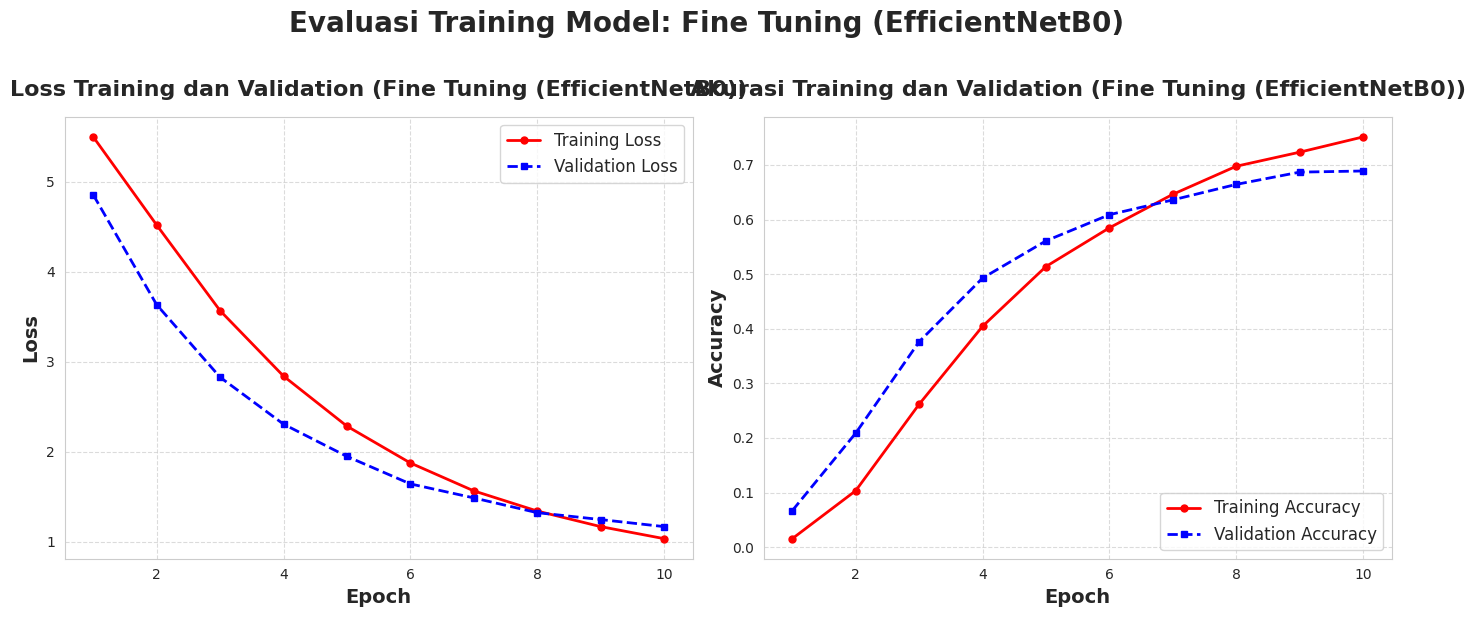

In [54]:
# --- Fungsi Plot (Sudah diperbaiki: fontweight='heavy') ---
def plot_training_history(history, model_name):
    """
    Membuat plot dari Loss dan Accuracy untuk training dan validation.
    """
    # Dapatkan metrik dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Tentukan gaya visual
    sns.set_style("whitegrid")

    # --- Plot Loss ---
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r-o', label='Training Loss', linewidth=2, markersize=5)
    plt.plot(epochs, val_loss, 'b--s', label='Validation Loss', linewidth=2, markersize=5)
    plt.title(f'Loss Training dan Validation ({model_name})', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r-o', label='Training Accuracy', linewidth=2, markersize=5)
    plt.plot(epochs, val_acc, 'b--s', label='Validation Accuracy', linewidth=2, markersize=5)
    plt.title(f'Akurasi Training dan Validation ({model_name})', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # JUDUL UTAMA (FIXED: menggunakan 'heavy' agar tidak error)
    plt.suptitle(f'Evaluasi Training Model: {model_name}', fontsize=20, fontweight='heavy', y=1.02)

    plt.tight_layout()
    plt.show()

# --- EKSEKUSI PLOT UNTUK FINE TUNING ---

# Pastikan variabel 'history_ft' ada (hasil dari model_ft.fit(...))
if 'history_ft' in locals():
    print("Menampilkan Grafik Akurasi & Loss untuk Fine Tuning...")
    plot_training_history(history_ft, 'Fine Tuning (EfficientNetB0)')
else:
    print("🚨 Error: Variabel 'history_ft' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan training fine tuning dan menyimpannya ke variabel 'history_ft'.")

### Testing Fine Tuning

In [55]:
# Upload file
uploaded = files.upload()  # Akan muncul tombol pilih file

# Ambil nama file yang diupload
img_path = list(uploaded.keys())[0]

# Load dan preprocess image
IMG_SIZE = (224, 224)  # sesuai model
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = loaded_model_ft.predict(img_array)

# Ambil index kelas dengan probabilitas tertinggi
pred_class_index = np.argmax(pred, axis=1)[0]
pred_score = pred[0][pred_class_index]

# Mapping index → nama kelas
class_names = list(train_generator_fine_tuning.class_indices.keys())  # ambil dari generator
pred_class_name = class_names[pred_class_index]

print(f"Predicted class: {pred_class_name}")
print(f"Score / Probability: {pred_score:.4f}")

Saving burung.webp to burung (4).webp


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 177.Prothonotary_Warbler
Score / Probability: 0.1748
